In [1]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [3]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN64 = Path('train64/')
TRAIN128 = Path('train128/')
TRAIN256 = Path('train256/')
TEST256 = Path('test256/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)
seg.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [4]:
from fastai.vision.data import _df_to_fns_labels

In [5]:
fnames, labels = _df_to_fns_labels(seg, label_delim=' ')

In [6]:
labels

array([list(['16', '0']), list(['7', '1', '2', '0']), list(['5']), list(['1']), ..., list(['5']), list(['7']),
       list(['25', '2', '21']), list(['2', '0'])], dtype=object)

In [7]:
classes = uniqueify(np.concatenate(labels)); classes

['16',
 '0',
 '7',
 '1',
 '2',
 '5',
 '18',
 '25',
 '23',
 '21',
 '24',
 '6',
 '11',
 '3',
 '12',
 '13',
 '14',
 '4',
 '20',
 '22',
 '17',
 '19',
 '8',
 '9',
 '10',
 '26',
 '27',
 '15']

In [8]:
norm,denorm = normalize_funcs(*imagenet_stats)

In [9]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.3)

In [15]:
data64 = ImageDataBunch.from_df(path=PATH, folder=TRAIN64, df=pd.read_csv(PATH/MASKS), sep=' ', suffix='.png',
                               bs = 512)
data128 = ImageDataBunch.from_df(path=PATH, folder=TRAIN128, df=pd.read_csv(PATH/MASKS), sep=' ', suffix='.png',
                                bs=128)
data256 = ImageDataBunch.from_df(path=PATH, folder=TRAIN256, df=pd.read_csv(PATH/MASKS), sep=' ', suffix='.png', 
                                 test=TEST256, bs = 64)

In [16]:
def f1(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>0.5).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

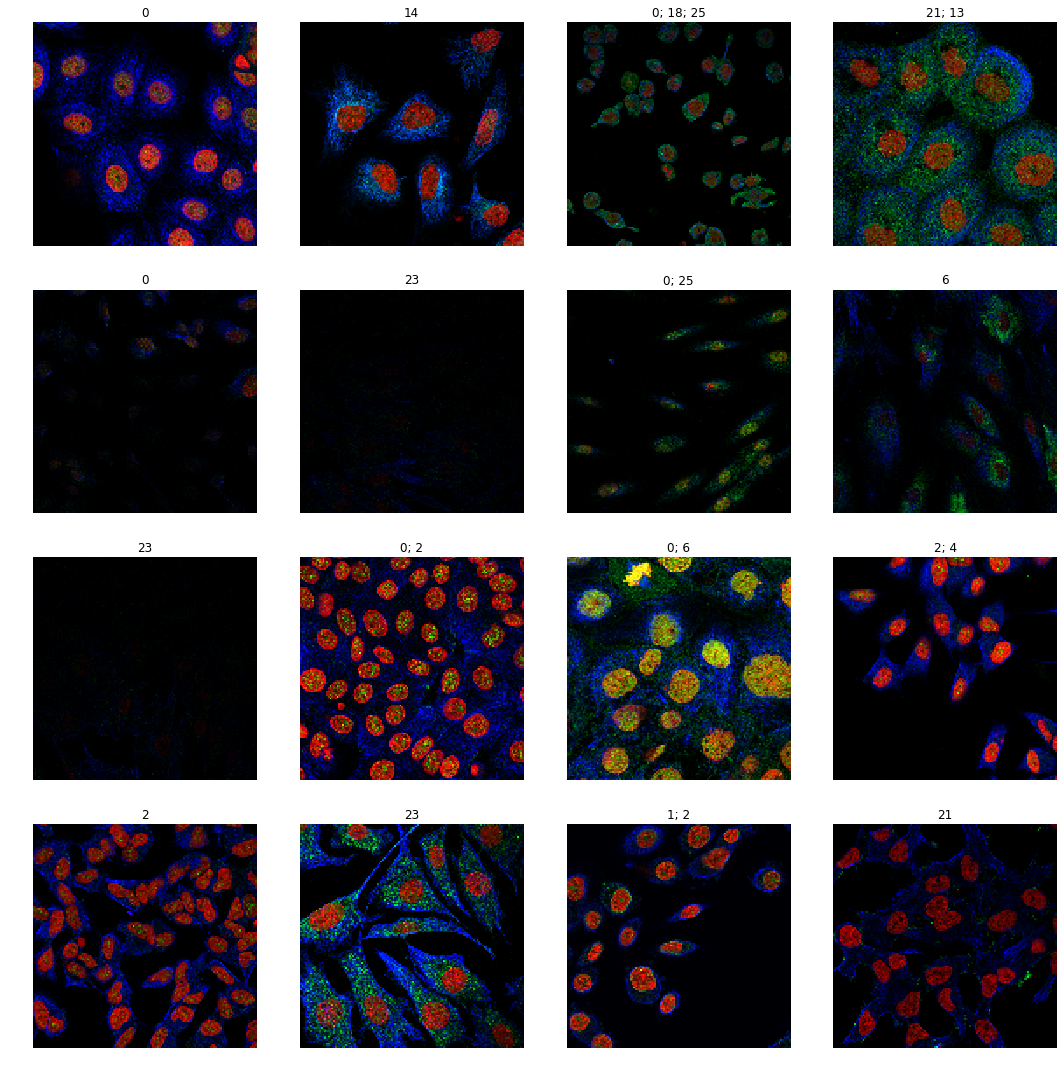

In [18]:
data128.show_batch(rows=4, figsize=(15,15))

In [19]:
from fastai.vision.models.darknet import *
darknet = Darknet([1,2,4,4], 28)
darknet53 = Darknet([1,2,8,8,4], 28)

In [22]:
learn = Learner(data128, darknet53, metrics=[accuracy_thresh, f1])
# learn = Learner(data256, model, metrics=[accuracy_thresh, f1])

In [23]:
learn.to_fp16();

In [24]:
def get_data(size):
    if size==64: return data64
    if size==128: return data128
    if size==256: return data256

def train_size(size, save_name, lr):
    learn.data=get_data(size)
    learn.fit_one_cycle(5, lr)
    learn.save(save_name)

In [25]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


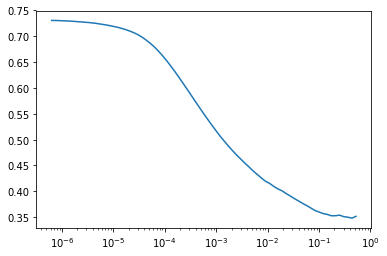

In [12]:
learn.recorder.plot()

In [26]:
lr=3e-3

In [27]:
learn.fit_one_cycle(10, lr)

Total time: 32:24
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.162796    nan         0.936593         0.225200  (03:13)
2      0.156896    0.164667    0.942729         0.300463  (03:14)
3      0.147190    0.180653    0.941311         0.217346  (03:14)
4      0.138508    0.140672    0.951155         0.359710  (03:14)
5      0.131994    0.146109    0.950324         0.409937  (03:14)
6      0.124860    0.145714    0.950774         0.412475  (03:14)
7      0.118855    0.125142    0.956010         0.475002  (03:14)
8      0.112971    0.126797    0.955416         0.424527  (03:14)
9      0.107479    0.112256    0.960318         0.526077  (03:15)
10     0.104958    0.110989    0.960762         0.532406  (03:14)



In [170]:
learn.save('hp64_10i')

In [172]:
learn.load('hp64_10i')

In [173]:
train_size(128,'hp128_5i', lr/10)

Total time: 35:42
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.133313    0.136399    0.953273         0.386164  (07:06)
2      0.133527    0.134663    0.953661         0.402481  (07:08)
3      0.127077    0.131590    0.954663         0.406213  (07:08)
4      0.122486    0.123805    0.957137         0.447383  (07:08)
5      0.121862    0.120533    0.957838         0.460870  (07:09)



In [ ]:
train_size(256, 'hp256_5i', lr/8)

In [161]:
learn.loss_func = FocalLoss()

In [162]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,1.233870,1.444677,0.942177,0.281927
2,1.216174,2.282011,0.937345,0.022605


KeyboardInterrupt: 

In [77]:
p_v,t_v = learn.get_preds()

In [78]:
p_v.shape, t_v.shape

(torch.Size([6299, 28]), torch.Size([6299, 28]))

In [79]:
f1(p_v,t_v)

torch.Size([6299, 28])


tensor(0.6631)

In [110]:
(p_v.sigmoid()>0.2).float().sum(0)

tensor([  15., 3524.,  608.,  263.,  880.,  507.,  200., 2813.,  685., 1216.,
          61.,  284.,  191.,  284.,  143.,  116.,  239.,  404.,   19.,  128.,
          24.,  277.,    8.,   10.,    8.,   48.,    0.,    1.])

In [104]:
t_v.sum(0)

tensor([  96., 2619.,  559.,  265.,  746.,  491.,  194., 1675.,  581.,  766.,
          64.,  188.,  232.,  351.,  136.,   99.,  225.,  385.,   38.,  159.,
          48.,  300.,    8.,    8.,    5.,   72.,    1.,    4.])

In [ ]:
th_lafoss = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])

# Generate sub file 

In [76]:
p,t = learn.get_preds(is_test=True)

In [75]:
t.shape, p.shape

(torch.Size([6221, 28]), torch.Size([6221, 28]))

In [89]:
dir = get_image_files(TEST256)
dir = [f.name[:-4] for f in dir]

In [90]:
dir[0:5]

['8f8c19a6-bacf-11e8-b2b8-ac1f6b6435d0',
 '5e63573a-bad0-11e8-b2b8-ac1f6b6435d0',
 '50885994-bad5-11e8-b2b9-ac1f6b6435d0',
 'f4f6cdfc-bac7-11e8-b2b7-ac1f6b6435d0',
 'a3a13e5e-bac9-11e8-b2b8-ac1f6b6435d0']

In [91]:
test_names[0:5]

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
 '0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
 '0008baca-bad7-11e8-b2b9-ac1f6b6435d0',
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']

In [123]:
preds = p.sigmoid()
threshold = 0.5
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

torch.Size([11702, 28])


In [124]:
filenames = np.array(test_names)
dir_names = np.array(dir)

In [125]:
frame = pd.DataFrame(np.array([dir_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('my_submission.csv', index=False)

In [126]:
#fix indexing
f1 = pd.read_csv('sample_submission.csv')
f1.drop('Predicted', axis=1, inplace=True)
f2 = pd.read_csv('my_submission.csv')
f1 = f1.merge(f2, left_on='Id', right_on='Id', how='outer')
f1.to_csv('my_new_submission.csv', index=False)